In [55]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress


#### Load Recipes Data

In [56]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipe to text document

In [57]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [58]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [59]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

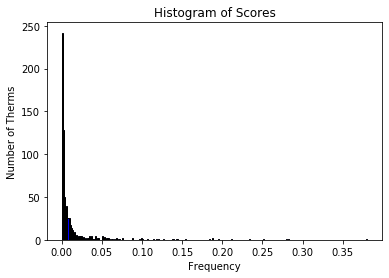

In [60]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [61]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    print('-------------')
    print(k)
    print(scores_df.iloc[:15,:])


-------------
greek
        term     score
0      fresh  0.297130
1     pepper  0.294340
2        oil  0.287714
3       salt  0.260512
4      olive  0.260163
5       feta  0.231165
6     ground  0.226684
7      lemon  0.224591
8     garlic  0.220058
9     cheese  0.202621
10   oregano  0.162209
11     juice  0.155540
12     dried  0.152750
13  tomatoes  0.147868
14     black  0.139847
-------------
southern_us
       term     score
0      salt  0.374617
1    pepper  0.329929
2     sugar  0.285364
3    butter  0.265297
4     flour  0.227380
5    ground  0.189832
6      eggs  0.170627
7    powder  0.160286
8       oil  0.157209
9       all  0.155608
10  purpose  0.155608
11   baking  0.151546
12     milk  0.137758
13    black  0.124462
14   garlic  0.121507
-------------
filipino
       term     score
0     sauce  0.327662
1    garlic  0.325087
2    pepper  0.323156
3      salt  0.309637
4       oil  0.306418
5    onions  0.252988
6     water  0.224020
7     sugar  0.205352
8       soy  

#### Load Baskets Market Data

In [62]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [63]:
top_scores_ngram = {}

for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>(statistics[cuisine][1]/4)]
    #scores_df = scores_df.iloc[:30,:]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [64]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs

In [65]:
baskets_scores = []

for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        for item in basket:      
            item_ngram = list(ngrams(item, 3))
            for ngram_term, score in top_scores_ngram[cuisine]:
                sim = jaccard_distance(item_ngram, ngram_term)
                if sim > 0:
                    value += sim * score
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 

#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [66]:
baskets_scores_df = pd.DataFrame(baskets_scores)
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [67]:
# OPTICS
optics = OPTICS(min_samples=20, max_eps=0.35, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{0, -1}


/home/nepotu/anaconda3/envs/dataMiningProject/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [68]:
# K-Means
kMeans = KMeans(n_clusters=10, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [69]:
# DBSCAN 
[eps, min_samples] = [0.35, 50]
dbScan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])

{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
[0.35, 50]


#### Analysis of the method
Observe size of created basket clusters

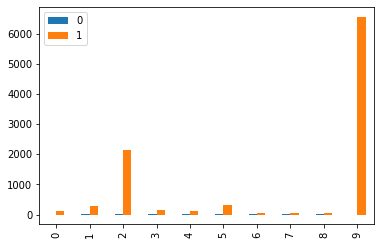

In [70]:
labels = dbScan_labels
cluster_sizes = []
for label in set(labels):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [71]:
for selected_basket_cluster in set(labels):
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    aggregated_basket_cluster_score \
        = np.sum(selected_basket_scores, axis=0)\
        .sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)


greek           11.187314
british          0.381030
indian           0.286883
irish            0.264374
thai             0.259857
mexican          0.234035
jamaican         0.226802
french           0.215894
russian          0.203913
southern_us      0.164796
japanese         0.154137
italian          0.097554
vietnamese       0.088406
brazilian        0.041743
cajun_creole     0.038040
chinese          0.025342
korean           0.018564
spanish          0.014068
filipino         0.008562
moroccan         0.000000
dtype: float64
brazilian       20.210575
irish           16.930142
british         16.322751
southern_us     15.698042
thai            11.350005
filipino         9.375932
russian          9.185357
french           8.445591
mexican          0.819875
indian           0.662678
jamaican         0.650509
vietnamese       0.383680
japanese         0.307174
greek            0.254599
italian          0.237782
chinese          0.196571
korean           0.078222
spanish          0.0722

 Calculate the most frequent terms (TF) of the cluster of baskets and
 compute the intersection between frequent terms of baskets clusters 
 and cuisine terms that scored high TF-IDF

In [ ]:
countVectorizer = CountVectorizer()
wordCountVector = countVectorizer.fit_transform(selected_baskets)
vocabulary = pd.Series(countVectorizer.vocabulary_)
vocabulary = vocabulary[vocabulary > 0].sort_values(ascending=False)
print(vocabulary)

intersection_therms = {}
frequent_basket_cluster_terms = set(vocabulary.index)
for cuisine in aggregated_basket_cluster_score.index:
    frequent_cuisine_therms = set(docs_scores_dfs[cuisine]["term"][0:50])
    print(len(frequent_basket_cluster_terms.intersection(frequent_cuisine_therms)))
    

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [73]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
for i in baseline_labels:
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 milk
 whole
 butter
 pastry
 bread
 yogurt
 newspapers
 brown
 cheese
 fruit
Cluster 1:
 buns
 rolls
 milk
 soda
 sausage
 whole
 frankfurter
 vegetables
 cheese
 yogurt
Cluster 2:
 soda
 chocolate
 pastry
 yogurt
 specialty
 newspapers
 coffee
 beverages
 bread
 sausage
Cluster 3:
 water
 bottled
 milk
 soda
 whole
 fruit
 beer
 vegetables
 rolls
 buns
Cluster 4:
 fruit
 tropical
 vegetable
 juice
 pip
 citrus
 milk
 vegetables
 yogurt
 whole
Cluster 5:
 life
 product
 bakery
 long
 fruit
 vegetables
 milk
 whole
 chocolate
 cheese
Cluster 6:
 vegetables
 other
 root
 milk
 whole
 fruit
 frozen
 yogurt
 cheese
 pork
Cluster 7:
 shopping
 bags
 soda
 milk
 beer
 canned
 vegetables
 sausage
 fruit
 rolls
Cluster 8:
 beer
 canned
 bottled
 soda
 liquor
 newspapers
 rolls
 buns
 vegetables
 water
Cluster 9:
 cream
 whipped
 sour
 vegetables
 milk
 fruit
 ice
 whole
 other
 cheese


#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines 

In [74]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[labels == cluster]
    cluster_scores = np.sum(basket_scores, axis=0).sort_values(ascending=False)
    cluster_scores = cluster_scores[0:50]
    print(cluster_scores)

greek           11.187314
british          0.381030
indian           0.286883
irish            0.264374
thai             0.259857
mexican          0.234035
jamaican         0.226802
french           0.215894
russian          0.203913
southern_us      0.164796
japanese         0.154137
italian          0.097554
vietnamese       0.088406
brazilian        0.041743
cajun_creole     0.038040
chinese          0.025342
korean           0.018564
spanish          0.014068
filipino         0.008562
moroccan         0.000000
dtype: float64
brazilian       20.210575
irish           16.930142
british         16.322751
southern_us     15.698042
thai            11.350005
filipino         9.375932
russian          9.185357
french           8.445591
mexican          0.819875
indian           0.662678
jamaican         0.650509
vietnamese       0.383680
japanese         0.307174
greek            0.254599
italian          0.237782
chinese          0.196571
korean           0.078222
spanish          0.0722